In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import os
import sys
from osgeo import ogr

from qgis.core import *
from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice




### Carregar os dados de covid dos Estados Unidos

- Dados provenientes do New York Times
    https://github.com/nytimes/covid-19-data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
df.head()
df = df.sort_values(by=['state','date'])
print(df)



            date    state  fips  cases  deaths
586   2020-03-13  Alabama     1      6       0
637   2020-03-14  Alabama     1     12       0
689   2020-03-15  Alabama     1     23       0
742   2020-03-16  Alabama     1     29       0
795   2020-03-17  Alabama     1     39       0
...          ...      ...   ...    ...     ...
2928  2020-04-24  Wyoming    56    349       7
2983  2020-04-25  Wyoming    56    362       7
3038  2020-04-26  Wyoming    56    371       7
3093  2020-04-27  Wyoming    56    389       7
3148  2020-04-28  Wyoming    56    396       7

[3149 rows x 5 columns]


## Evolução temporal do Covid no estado de Nova York

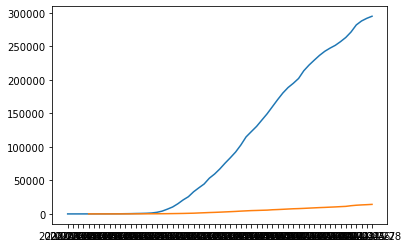

In [3]:
import matplotlib.pyplot as plt

def drawStateLine(state):
    data = df.loc[df.state==state].sort_values('date')
    plt.plot(data['date'],data['cases'])

drawStateLine('New York')
drawStateLine('Colorado')

### Atualizar os valores automaticamente do mapa

O notebook consegue construir o mapa para qualquer dia disponivel no csv

De momento está a construir o mapa para a data mais recente.

In [4]:

dayX = df.loc[df['date']==df['date'].drop_duplicates().max()]

#dayX = df.loc[df['date']=='2020-04-28']

print(dayX)

            date                     state  fips   cases  deaths
3094  2020-04-28                   Alabama     1    6750     242
3095  2020-04-28                    Alaska     2     349       7
3096  2020-04-28                   Arizona     4    6948     297
3097  2020-04-28                  Arkansas     5    3127      57
3098  2020-04-28                California     6   46570    1884
3099  2020-04-28                  Colorado     8   14239     734
3100  2020-04-28               Connecticut     9   26312    2089
3101  2020-04-28                  Delaware    10    4575     137
3102  2020-04-28      District of Columbia    11    3994     190
3103  2020-04-28                   Florida    12   32838    1170
3104  2020-04-28                   Georgia    13   23607    1022
3105  2020-04-28                      Guam    66    1001       6
3106  2020-04-28                    Hawaii    15     602      16
3107  2020-04-28                     Idaho    16    1810      60
3108  2020-04-28         

In [5]:
qgs = QgsApplication([], False)
qgs.initQgis()
print(QgsApplication.showSettings())

Application state:
QGIS_PREFIX_PATH env var:		C:/OSGEO4~1/apps/qgis
Prefix:		C:/OSGEO4~1/apps/qgis
Plugin Path:		C:/OSGEO4~1/apps/qgis/plugins
Package Data Path:	C:/OSGEO4~1/apps/qgis/.
Active Theme Name:	
Active Theme Path:	C:/OSGEO4~1/apps/qgis/./resources/themes\\icons/
Default Theme Path:	:/images/themes/default/
SVG Search Paths:	C:/OSGEO4~1/apps/qgis/./svg/
		C:/Users/josef/AppData/Roaming/python\profiles\default/svg/
User DB Path:	C:/OSGEO4~1/apps/qgis/./resources/qgis.db
Auth DB Path:	C:/Users/josef/AppData/Roaming/python\profiles\default/qgis-auth.db



In [6]:
GPKG = "USA"


covid_gpkg = f"{GPKG}.gpkg"
project = QgsProject.instance()
project.read("USMAP.qgs")


True

In [7]:
from qgis.PyQt.QtCore import *
from qgis.PyQt.QtGui import *

states = QgsProject.instance().mapLayersByName(GPKG)[0]

states.dataProvider().addAttributes([QgsField("cases", QVariant.Int)])
states.dataProvider().addAttributes([QgsField("deaths", QVariant.Int)])
states.updateFields()
print(states.fields().names())

['fid', 'featurecla', 'scalerank', 'adm1_code', 'diss_me', 'iso_3166_2', 'wikipedia', 'iso_a2', 'adm0_sr', 'name', 'name_alt', 'name_local', 'type', 'type_en', 'code_local', 'code_hasc', 'note', 'hasc_maybe', 'region', 'region_cod', 'provnum_ne', 'gadm_level', 'check_me', 'datarank', 'abbrev', 'postal', 'area_sqkm', 'sameascity', 'labelrank', 'name_len', 'mapcolor9', 'mapcolor13', 'fips', 'fips_alt', 'woe_id', 'woe_label', 'woe_name', 'latitude', 'longitude', 'sov_a3', 'adm0_a3', 'adm0_label', 'admin', 'geonunit', 'gu_a3', 'gn_id', 'gn_name', 'gns_id', 'gns_name', 'gn_level', 'gn_region', 'gn_a1_code', 'region_sub', 'sub_code', 'gns_level', 'gns_lang', 'gns_adm1', 'gns_region', 'min_label', 'max_label', 'min_zoom', 'wikidataid', 'name_ar', 'name_bn', 'name_de', 'name_en', 'name_es', 'name_fr', 'name_el', 'name_hi', 'name_hu', 'name_id', 'name_it', 'name_ja', 'name_ko', 'name_nl', 'name_pl', 'name_pt', 'name_ru', 'name_sv', 'name_tr', 'name_vi', 'name_zh', 'ne_id', 'cases', 'deaths']


In [8]:
casesIdx = states.dataProvider().fields().indexFromName( 'cases' )
deathsIdx = states.dataProvider().fields().indexFromName( 'deaths' )
    
updateMap = {}
for c in states.getFeatures():    
    cases = int(0)
    deaths = int(0)
    try:
        cases = int(dayX.loc[dayX['state']==c['name'],'cases'])
        deahts = int(dayX.loc[dayX['state']==c['name'],'deaths'])       
    except:
        cases = int(0)
        deaths = int(0)
        
    updateMap[c.id()] = { casesIdx : cases 
        , deathsIdx : deaths
        } 

states.dataProvider().changeAttributeValues( updateMap )


True

### Desenhar o mapa

A escala das cores tem de ser recalculada no QGIS neste momento 

In [9]:
xt = states.extent()
# print(xt)
scale = 40
width  = xt.width()*scale
height = xt.height()*scale #int(width*xt.height()/xt.width())
print("Gerar mapa com {} por {}".format(width, height))

options = QgsMapSettings()
options.setLayers([states])
options.setBackgroundColor(QColor(27, 27, 44))
options.setOutputSize(QSize(width, height))
options.setExtent(xt)

render = QgsMapRendererParallelJob(options)
render.start()
render.waitForFinished()

image = render.renderedImage()

Gerar mapa com 4456.497987720004 por 1218.5350791382575


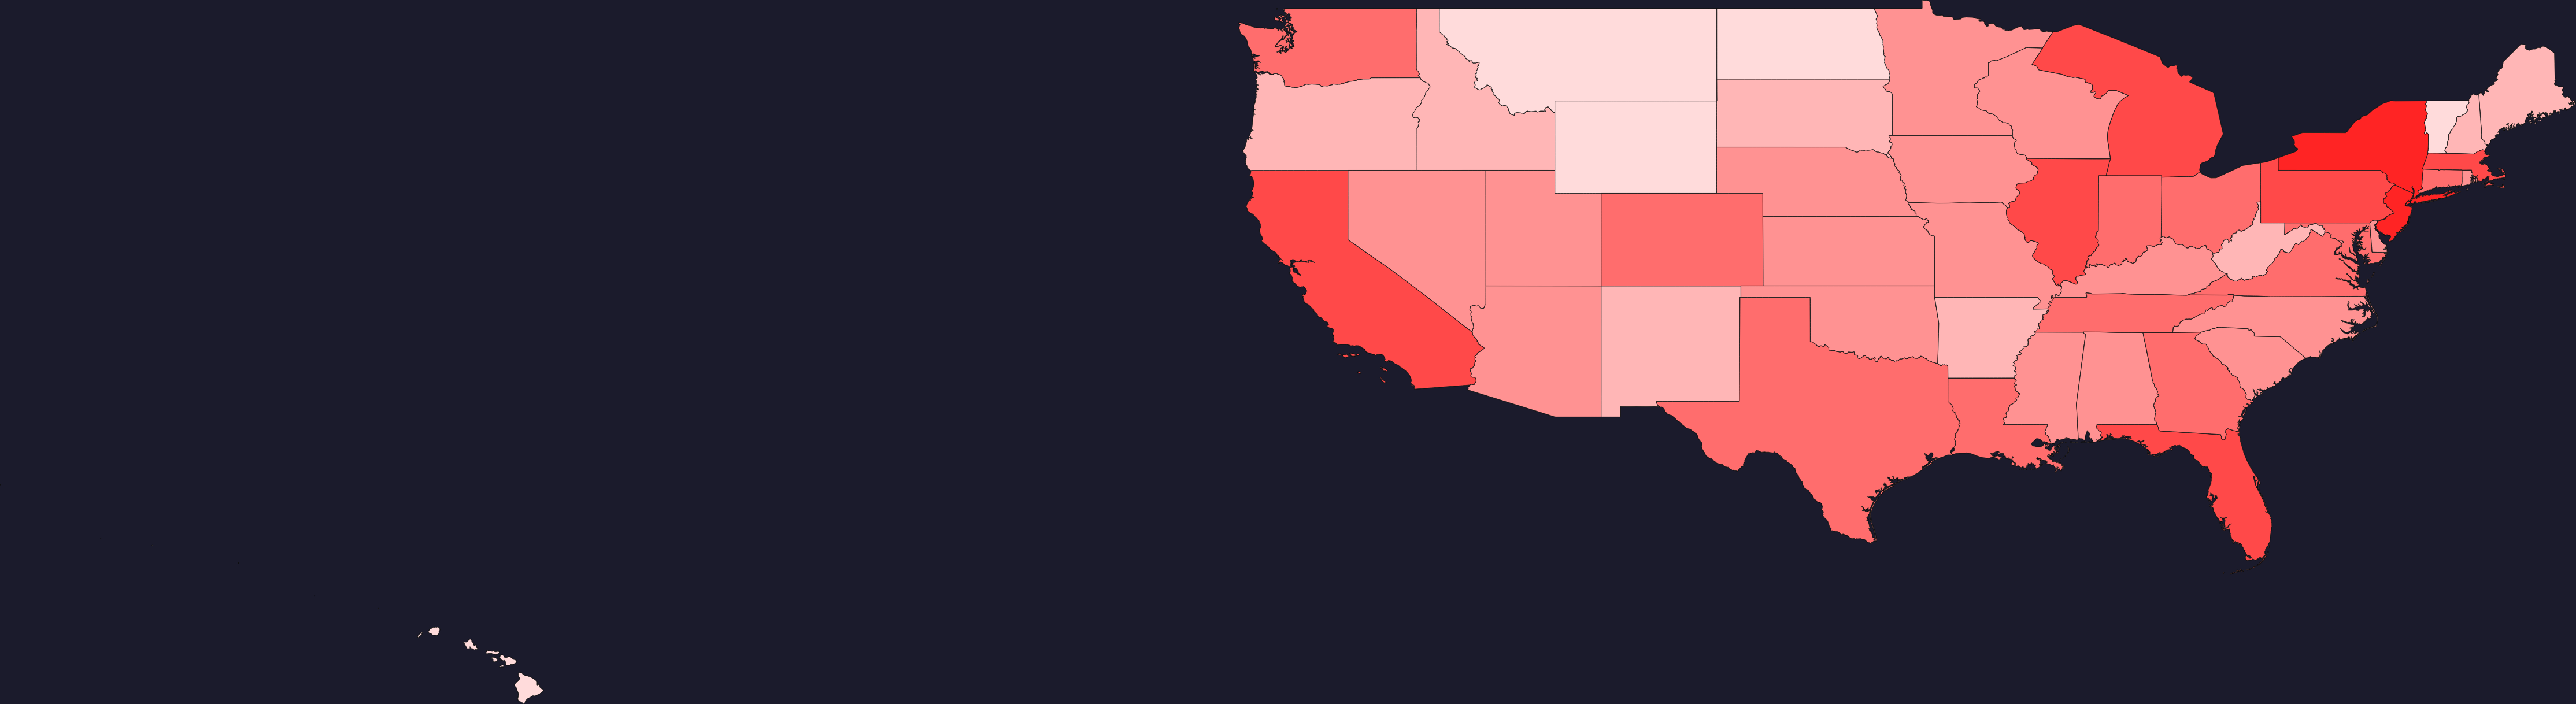

In [10]:
from IPython.display import Image
imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )